In [1]:
import numpy as np
from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import linregress
import xarray as xr
import pandas as pd 

In [1]:
# helper function to convert a single 1-D timeseries into a 2-D grid, with day-of-year on the x-axis and year on the y-axis
# we remove leap days
# also need to remember the final year has incomplete data and needs filling out with NaNs

def convert_to_grid(ds):
	df = ds.to_dataframe()
	df = df[~((df.index.month ==2) & (df.index.day == 29))]
	
	if df.index[-1].year == 2022 and len(df[df.index.year==2022]) < 365:
		fill_index = pd.date_range(start='2022-01-01', end='2022-12-31')
		df_2022 = df[df.index.year ==2022].reindex(fill_index)
		df = pd.concat([df[df.index.year !=2022], df_2022])
	
	n_years = df.index.year.nunique()
	arr = df['modelled_grid_output'].to_numpy().reshape((n_years, 365))
	
	arr[arr>1000] = np.nan
	
	return arr
	

In [3]:
# load in precomputed synthetic timeseries of solar and wind output (available here: https://zenodo.org/records/7824872)

solar_total = xr.open_dataset("../../capacity/data-for-export/modelled-historical-daily-solar_output.nc")
wind_total = xr.open_dataset("../../capacity/data-for-export/modelled-historical-daily-wind_output.nc")


wind_total = convert_to_grid(wind_total)
solar_total = convert_to_grid(solar_total)

total_produced = wind_total + solar_total

In [4]:
#load in the colour map
cmap_name = 'cmp_b2r'
rgb = np.genfromtxt("../other-files/colourmaps/{}.rgb".format(cmap_name))/255.
cmap = LinearSegmentedColormap.from_list(cmap_name, rgb, N=20)

In [7]:
%matplotlib inline
plt.ioff()

doys = np.arange(1,366)
years = np.arange(1979,2023)

plt.figure(figsize=(8,4))
plt.pcolormesh(doys,years,total_produced, cmap=cmap,)

In [8]:
deficient = total_produced<np.nanpercentile(total_produced, 1)
dx, dy = np.where(deficient)
plt.plot(doys[dy], years[dx], marker = 'o', mfc = 'yellow', lw=0, mec='k', mew=0.5)
counts = np.array([np.sum(dx==i) for i in range(42)])
print(np.mean(counts))
print(linregress(range(42), counts))


3.357142857142857
LinregressResult(slope=0.007859978932015238, intercept=3.1960132890365447, rvalue=0.03111933964168867, pvalue=0.8448940426594139, stderr=0.039916331756548615, intercept_stderr=0.9506178674664522)


In [9]:
surplus = total_produced>np.nanpercentile(total_produced, 99)
dx, dy = np.where(surplus)
plt.plot(doys[dy], years[dx], marker = 'o', mfc = 'grey', lw=0, mec='k', mew=0.5)
counts = np.array([np.sum(dx==i) for i in range(42)])
print(np.mean(counts))
print(linregress(range(42), counts))

3.761904761904762
LinregressResult(slope=-0.061421278664613894, intercept=5.021040974529347, rvalue=-0.2265339983613263, pvalue=0.14912368361201073, stderr=0.041755710418881924, intercept_stderr=0.9944231507804361)


<Figure size 800x400 with 0 Axes>

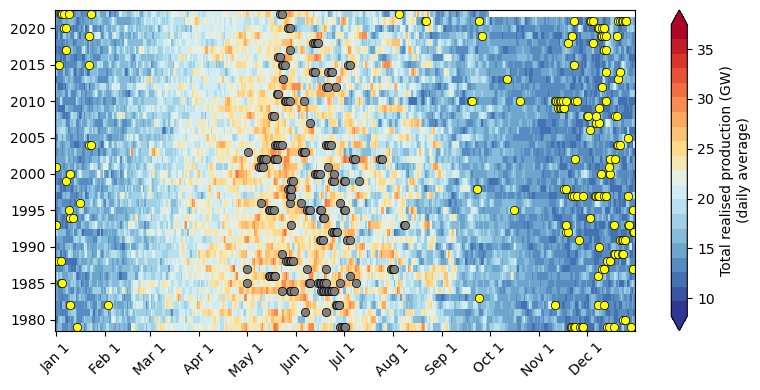

In [10]:
plt.xticks([1,32,60,91,121,152,182,213,244,274,305,335])
plt.gca().set_xticklabels(['Jan 1', 'Feb 1', 'Mar 1', 'Apr 1', 'May 1', 'Jun 1',
                 'Jul 1', 'Aug 1', 'Sep 1', 'Oct 1', 'Nov 1', 'Dec 1'], 
					 rotation=45)


cb = plt.colorbar(extend='both')
cb.set_label("Total realised production (GW)\n(daily average)")


plt.tight_layout()
plt.show()